### Import 

In [17]:
import numpy as np
import pandas as pd
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

### Dataset 

In [18]:
class Dataset:
    def __init__(self):
        self.transform = transforms.ToTensor()
        self.trainset = self.load_train_data()
        self.testset = self.load_test_data()
        
             
    def load_train_data(self):
        trainset = ds.FashionMNIST(root='./data', train=True, download=True, transform=self.transform)
        return trainset

    def load_test_data(self):
        testset = ds.FashionMNIST(root='./data', train=False, download=True, transform=self.transform)
        return testset
    
    def get_train_data(self):
        return self.trainset
    
    def get_test_data(self):
        return self.testset
    
    def split_data(self, data, test_size=0.2):

        train_data, val_data = train_test_split(data, test_size=test_size, random_state=42)
        
        return train_data, val_data
    
    def preprocess_FashionMNIST(self, data):
        processed_data = []

        for i in range(len(data)):
            image, label = data[i]
            image = image.numpy().flatten()
            image = image / 255.0
            if np.isnan(label) == False:
                processed_data.append([image, label])

        processed_data = np.array(processed_data, dtype=object)
        return processed_data
    
    def get_data(self):
        train_data = self.preprocess_FashionMNIST(self.trainset)
        test_data = self.preprocess_FashionMNIST(self.testset)

        train_data, val_data = self.split_data(train_data)

        X_train = np.array([i[0] for i in train_data])
        y_train = np.array([i[1] for i in train_data])
        X_val = np.array([i[0] for i in val_data])
        y_val = np.array([i[1] for i in val_data])
        X_test = np.array([i[0] for i in test_data])
        y_test = np.array([i[1] for i in test_data])
        
        y_train = self.one_hot(y_train)
        y_val = self.one_hot(y_val)
        y_test = self.one_hot(y_test)

        return X_train, y_train, X_val, y_val, X_test, y_test
    
    #one hot encoding for the labels
    def one_hot(self, y):
        n_values = 10
        y = y.astype(int)
        y =  np.eye(n_values)[y.reshape(-1)]
        return y
        
    



### Layer

In [19]:
class Layer:
    def forward(self, X):
        raise NotImplementedError
    
    def backward(self, output_grad, learning_rate):
        raise NotImplementedError


### Optimizer

In [20]:
# class AdamOptimizer:
#     def __init__(self,  beta1=0.9, beta2=0.999, epsilon=1e-8):
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.epsilon = epsilon
#         self.m_weights = None
#         self.v_weights = None
#         self.m_bias = None
#         self.v_bias = None
#         self.t = 0

#     def update(self, weights, bias, weights_grad, bias_grad, learning_rate):
#         self.t += 1
#         if self.m_weights is None:
#             self.m_weights = np.zeros_like(weights_grad)
#             self.v_weights = np.zeros_like(weights_grad)
#             self.m_bias = np.zeros_like(bias_grad)
#             self.v_bias = np.zeros_like(bias_grad)

#         self.m_weights = self.beta1 * self.m_weights + (1 - self.beta1) * weights_grad
#         self.v_weights = self.beta2 * self.v_weights + (1 - self.beta2) * weights_grad**2
#         self.m_bias = self.beta1 * self.m_bias + (1 - self.beta1) * bias_grad
#         self.v_bias = self.beta2 * self.v_bias + (1 - self.beta2) * bias_grad**2

#         m_weights_hat = self.m_weights / (1 - self.beta1**self.t)
#         v_weights_hat = self.v_weights / (1 - self.beta2**self.t)
#         m_bias_hat = self.m_bias / (1 - self.beta1**self.t)
#         v_bias_hat = self.v_bias / (1 - self.beta2**self.t)

#         weights_update = learning_rate * m_weights_hat / (np.sqrt(v_weights_hat) + self.epsilon)
#         bias_update = learning_rate * m_bias_hat / (np.sqrt(v_bias_hat) + self.epsilon)

#         weights = weights - weights_update
#         bias = bias - bias_update

#         return weights, bias


class AdamOptimizer:
    def __init__(self,  beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def minimize(self, weights, bias, weights_grad, bias_grad, learning_rate):
        self.t += 1
        # combine weights and bias gradients
        combined = np.concatenate([weights_grad.flatten(), bias_grad.flatten()])
        if self.m is None:
            self.m = np.zeros_like(combined)
            self.v = np.zeros_like(combined)

        self.m = self.beta1 * self.m + (1 - self.beta1) * combined
        self.v = self.beta2 * self.v + (1 - self.beta2) * combined**2

        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        combined_update = learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        weights_update = combined_update[:weights.size].reshape(weights.shape)
        bias_update = combined_update[weights.size:]

        weights = weights - weights_update
        bias = bias - bias_update

        return weights, bias
        


### Dense Layer

In [21]:
# class DenseLayer(Layer):
#     def __init__(self, input_dim, output_dim):
#         self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
#         self.bias = np.zeros((1, output_dim))
#         self.output = None
    
#     def forward(self, X):
#         self.input = X
#         self.output = np.dot(X, self.weights) + self.bias
#         return self.output
    
#     def backward(self, d_out):
#         d_weights = np.dot(self.input.T, d_out)
#         d_bias = np.sum(d_out, axis=0, keepdims=True)
#         d_input = np.dot(d_out, self.weights.T)
        
#         self.d_weights = d_weights
#         self.d_bias = d_bias
#         self.d_input = d_input
#         return d_input

def xavier_init(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = xavier_init(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None
        self.input_size = input_size
        self.output_size = output_size
        self.optimizer = AdamOptimizer()

    def forward(self, X):
        self.input = X
        self.output = np.dot(X, self.weights) + self.bias
        return self.output
    
    def backward(self, output_grad, learning_rate):
        input_grad = np.dot(output_grad, self.weights.T)
        weights_grad = np.dot(self.input.T, output_grad)
        bias_grad = np.sum(output_grad, axis=0, keepdims=True)

        self.weights , self.bias = self.optimizer.minimize(self.weights, self.bias, weights_grad, bias_grad, learning_rate)
        return input_grad


### ReLU Layer 

In [22]:
# class ReLULayer(Layer):
#     def forward(self, X):
#         self.input = X
#         self.output = self.relu(X)
#         return self.output
    
#     def backward(self, d_out):
#         self.d_input = d_out * np.where(self.input > 0, 1, 0)
#         return self.d_input
        
#     def relu(self, x):
#         return np.maximum(x, 0)
    
#     def relu_derivative(self, x):
#         return np.where(x > 0, 1, 0)

class ReLULayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = np.maximum(X, 0)
        return self.output
    
    def backward(self, output_grad, learning_rate):
        return output_grad * np.where(self.input > 0, 1, 0)
       

### Tanh Layer

In [23]:
class TanhLayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = np.tanh(X)
        return self.output
    
    def backward(self, output_grad, learning_rate):
        return output_grad * (1 - np.tanh(self.input)**2)


### Sigmoid Layer

In [24]:
class SigmoidLayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = self.sigmoid(X)
        return self.output
    
    def backward(self, output_grad, learning_rate):
        return output_grad * self.output * (1 - self.output)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

### Softmax Layer

In [25]:
class SoftmaxLayer(Layer):
    
    def forward(self, X):
        self.input = X
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output
    
    def backward(self, output_grad, learning_rate):
        input_gradient = np.multiply(output_grad, np.ones(self.input.shape))
        # input_gradient = self.output - output_grad
        return input_gradient
        

### Dropout Layer

In [26]:
class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
        self.mask = None
    
    def forward(self, X, training=True):
        self.input = X

        if training == False or self.p == 0:
            self.output = X
            return self.output
        
        if self.p == 1 :
            self.output = np.zeros(X.shape)
            return self.output
        
        self.mask = np.random.binomial(1, self.p, size=X.shape) / self.p
        self.output = X * self.mask
        return self.output
    
    def backward(self, output_grad, learning_rate, training=True):
        if training == False or self.p == 0:
            return output_grad
        return output_grad * self.mask

### Batch Normalization Layer

In [27]:

    
class BatchNormLayer(Layer):
    def __init__(self, input_size, epsilon=1e-8, momentum=0.9):
        self.input_size = input_size
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.momentum = momentum  # Momentum for running mean and variance

        # Trainable parameters: scale (gamma) and shift (beta)
        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))

        # Running mean and variance (used for inference)
        self.running_mean = np.zeros((1, input_size))
        self.running_var = np.ones((1, input_size))

        # Caches for backward pass
        self.input = None
        self.normalized_input = None
        self.batch_mean = None
        self.batch_var = None

        # Optimizer for gamma and beta
        self.optimizer = AdamOptimizer()

    def forward(self, X, training=True):
        
        self.input = X

        if training:
            # Compute mean and variance for the batch
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)

            # Normalize the input
            self.normalized_input = (X - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)

            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            # Use running statistics during inference
            self.normalized_input = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        # Scale and shift the normalized input
        output = self.gamma * self.normalized_input + self.beta
        return output

    def backward(self, output_grad, learning_rate):
        
        m = self.input.shape[0]  # Batch size

        # Gradients with respect to gamma and beta
        gamma_grad = np.sum(output_grad * self.normalized_input, axis=0, keepdims=True)
        beta_grad = np.sum(output_grad, axis=0, keepdims=True)

        # Gradient with respect to the normalized input
        normalized_grad = output_grad * self.gamma

        # Gradients with respect to input, mean, and variance
        var_grad = np.sum(normalized_grad * (self.input - self.batch_mean) * -0.5 * (self.batch_var + self.epsilon) ** (-1.5), axis=0, keepdims=True)
        mean_grad = np.sum(normalized_grad * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0, keepdims=True) + var_grad * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)

        # Gradient with respect to input
        input_grad = normalized_grad / np.sqrt(self.batch_var + self.epsilon) + var_grad * 2 * (self.input - self.batch_mean) / m + mean_grad / m

        # Update gamma and beta using Adam optimizer
        self.gamma, self.beta = self.optimizer.minimize(self.gamma, self.beta, gamma_grad, beta_grad, learning_rate)

        return input_grad


### Cross Entropy Loss

In [28]:

class CrossEntropyLoss:
    def __init__(self):
        self.epsilon = 1e-15  # To avoid log(0) and division by 0

    def loss(self, y_true, output):
        output = np.clip(output, self.epsilon, 1 - self.epsilon)
        loss = np.mean(-np.sum(y_true * np.log(output), axis=1))
        return loss

    def loss_prime(self, y_true, output):
        return (output - y_true) / y_true.shape[0]
        

### Neural Network

In [29]:
class NeuralNetwork:
    def __init__(self, layers):
        
        self.layers = layers  # Store all layers sequentially
        self.loss_fn = CrossEntropyLoss()  # Loss function

    def forward_propagation(self, X, training=True):
        
        output = X
        for layer in self.layers:
            if isinstance(layer, DropoutLayer) or isinstance(layer, BatchNormLayer):
                output = layer.forward(output, training=training) 
            else:
                output = layer.forward(output)
        return output
    
    def backward_propagation(self, output_grad, learning_rate):
       
        grad = output_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

    
    def fit(self, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.001, batch_size=32):
        
        num_samples = X_train.shape[0]

        training_losses = []
        validation_losses = []
        training_accuracies = []
        validation_accuracies = []
        training_f1_scores = []
        validation_f1_scores = []

        for epoch in range(epochs):
            error = 0
            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                output = self.forward_propagation(X_batch)
                loss = self.loss_fn.loss(y_batch, output)
                error += loss
                grad = self.loss_fn.loss_prime(y_batch, output)
                self.backward_propagation(grad, learning_rate)


            training_loss = error / (num_samples // batch_size)
            training_losses.append(training_loss)

            y_pred = self.predict(X_train)
            y_true = np.argmax(y_train, axis=1)
            training_accuracy = accuracy_score(y_true, y_pred)
            training_accuracies.append(training_accuracy)
            training_f1 = f1_score(y_true, y_pred, average='macro')
            training_f1_scores.append(training_f1)

            val_output = self.forward_propagation(X_val, training=False)
            validation_loss = self.loss_fn.loss(y_val, val_output)
            validation_losses.append(validation_loss)

            y_pred = self.predict(X_val)
            y_true = np.argmax(y_val, axis=1)
            validation_accuracy = accuracy_score(y_true, y_pred)
            validation_accuracies.append(validation_accuracy)
            validation_f1 = f1_score(y_true, y_pred, average='macro')
            validation_f1_scores.append(validation_f1)

            print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {training_loss:.4f} - Validation Loss: {validation_loss:.4f} - Training Accuracy: {training_accuracy:.4f} - Validation Accuracy: {validation_accuracy:.4f} - Training F1: {training_f1:.4f} - Validation F1: {validation_f1:.4f}')

        return training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores
    
            
    def predict(self, X):
        output = self.forward_propagation(X, training=False)
        return np.argmax(output, axis=1)



### Performance Metrics

In [30]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)
(10000, 784) (10000, 10)
Epoch 1/50 - Training Loss: 0.6972 - Validation Loss: 0.4253 - Training Accuracy: 0.8531 - Validation Accuracy: 0.8476 - Training F1: 0.8506 - Validation F1: 0.8456
Epoch 2/50 - Training Loss: 0.5222 - Validation Loss: 0.4086 - Training Accuracy: 0.8595 - Validation Accuracy: 0.8523 - Training F1: 0.8564 - Validation F1: 0.8496
Epoch 3/50 - Training Loss: 0.4896 - Validation Loss: 0.3971 - Training Accuracy: 0.8649 - Validation Accuracy: 0.8585 - Training F1: 0.8638 - Validation F1: 0.8579
Epoch 4/50 - Training Loss: 0.4729 - Validation Loss: 0.3825 - Training Accuracy: 0.8704 - Validation Accuracy: 0.8618 - Training F1: 0.8695 - Validation F1: 0.8614
Epoch 5/50 - Training Loss: 0.4542 - Validation Loss: 0.3809 - Training Accuracy: 0.8722 - Validation Accuracy: 0.8629 - Training F1: 0.8708 - Validation F1: 0.8621
Epoch 6/50 - Training Loss: 0.4447 - Validation Loss: 0.3680 - Training Accuracy: 0.8782 - Validatio

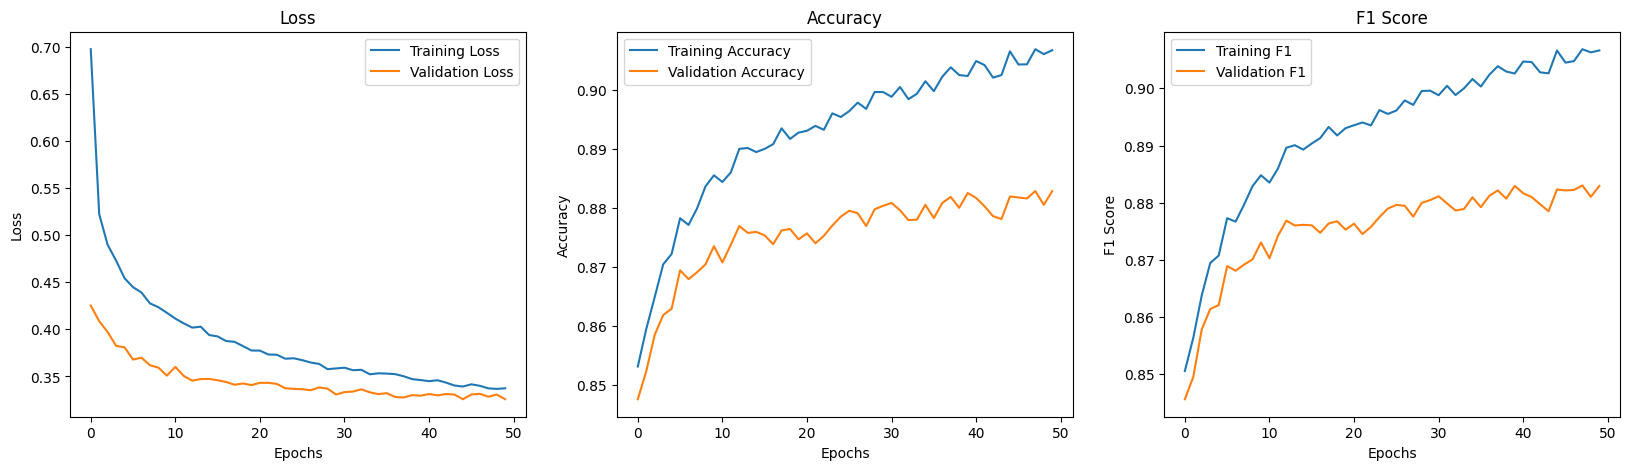

Test Accuracy: 0.8739
Test F1: 0.8738


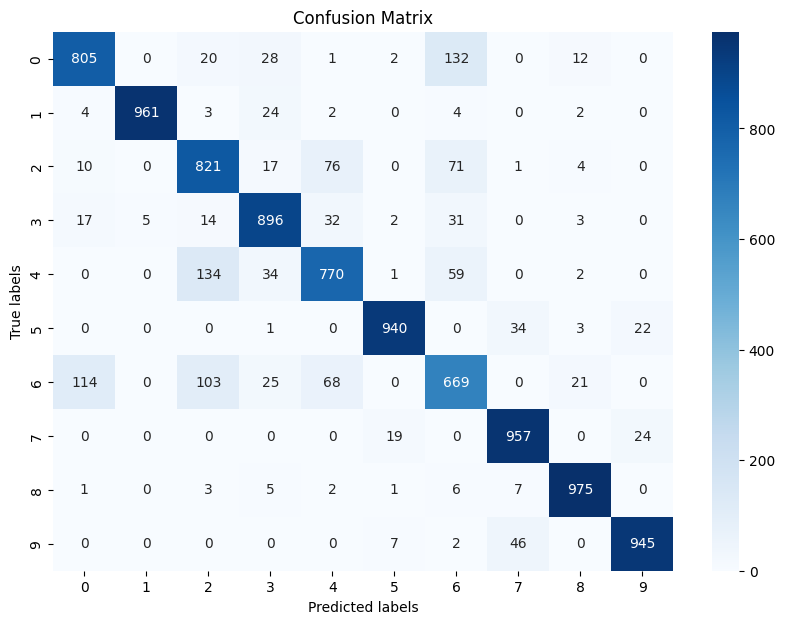

In [31]:

ds = Dataset()
X_train, y_train, X_val, y_val, X_test, y_test = ds.get_data()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# model 1
# layers = [
#     DenseLayer(784, 256),
#     ReLULayer(),
#     BatchNormLayer(256),
#     DropoutLayer(0.5),
#     DenseLayer(256, 128),
#     ReLULayer(),
#     BatchNormLayer(128),
#     DropoutLayer(0.5),
#     DenseLayer(128, 64),
#     ReLULayer(),
#     BatchNormLayer(64),
#     DropoutLayer(0.5),
#     DenseLayer(64, 10),
#     SoftmaxLayer()
# ]

# model 2
layers = [
    DenseLayer(784, 512),
    ReLULayer(),
    BatchNormLayer(512),
    DropoutLayer(0.5),
    DenseLayer(512, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 10),
    SoftmaxLayer()
]

nn = NeuralNetwork(layers)
train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = nn.fit(X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32)
plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)

y_pred = nn.predict(X_test)
y_true = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

plot_confusion_matrix(y_true, y_pred)

with open('nn_model.pkl', 'wb') as f:
    pickle.dump(nn, f)


